# Preparation



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# suppress warnings
import warnings;
warnings.filterwarnings("ignore");

# common imports
import pandas as pd
import numpy as np
import re
import glob
import os
import json
import random
import pprint as pp
import html
import nltk

from tqdm.auto import tqdm
# register pandas
tqdm.pandas()

import matplotlib
from matplotlib import pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

pd.set_option('display.max_colwidth',None)

In [ ]:
# change to current directory
BASE_DIR = "/content/drive/MyDrive/"
os.chdir(BASE_DIR)

In [ ]:
path = "./df_yelp_reviews.pkl"
df = pd.read_pickle(path)

In [ ]:
df.head()

,stars,text,length,tokens,num_of_tokens
0,3.0,"If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. The food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.",513,"[decide, eat, aware, going, take, 2, hours, beginning, end, tried, multiple, times, want, like, locations, nj, never, bad, experience, food, good, takes, long, time, come, waitstaff, young, usually, pleasant, many, experiences, spent, way, long, waiting, usually, opt, another, diner, restaurant, weekends, order, done, quicker]",44
1,5.0,"I've taken a lot of spin classes over the years, and nothing compares to the classes at Body Cycle. From the nice, clean space and amazing bikes, to the welcoming and motivating instructors, every class is a top notch work out. For anyone who struggles to fit workouts in, the online scheduling system makes it easy to plan ahead (and there's no need to line up way in advanced like many gyms make you do). There is no way I can write this review without giving Russell, the owner of Body Cycle, a shout out. Russell's passion for fitness and cycling is so evident, as is his desire for all of his clients to succeed. He is always dropping in to classes to check in/provide encouragement, and is open to ideas and recommendations from anyone. Russell always wears a smile on his face, even when he's kicking your butt in class!",829,"[taken, lot, spin, classes, years, nothing, compares, classes, body, cycle, nice, clean, space, amazing, bikes, welcoming, motivating, instructors, every, class, top, notch, work, anyone, struggles, fit, workouts, online, scheduling, system, makes, easy, plan, ahead, there's, need, line, way, advanced, like, many, gyms, make, way, write, review, without, giving, russell, owner, body, cycle, shout, russell's, passion, fitness, cycling, evident, desire, clients, succeed, always, dropping, classes, check, provide, encouragement, open, ideas, recommendations, anyone, russell, always, wears, smile, face, even, kicking, butt, class]",80
2,3.0,"Family diner. Had the buffet. Eclectic assortment: a large chicken leg, fried jalapeño, tamale, two rolled grape leaves, fresh melon. All good. Lots of Mexican choices there. Also has a menu with breakfast served all day long. Friendly, attentive staff. Good place for a casual relaxed meal with no expectations. Next to the Clarion Hotel.",339,"[family, diner, buffet, eclectic, assortment, large, chicken, leg, fried, jalape, tamale, two, rolled, grape, leaves, fresh, melon, good, lots, mexican, choices, also, menu, breakfast, served, day, long, friendly, attentive, staff, good, place, casual, relaxed, meal, expectations, next, clarion, hotel]",39
3,5.0,"Wow! Yummy, different, delicious. Our favorite is the lamb curry and korma. With 10 different kinds of naan!!! Don't let the outside deter you (because we almost changed our minds)...go in and try something new! You'll be glad you did!",243,"[wow, yummy, different, delicious, favorite, lamb, curry, korma, 10, different, kinds, naan, let, outside, deter, almost, changed, minds, go, try, something, new, glad]",23
4,4.0,"Cute interior and owner (?) gave us tour of upcoming patio/rooftop area which will be great on beautiful days like today. Cheese curds were very good and very filling. Really like that sandwiches come w salad, esp after eating too many curds! Had the onion, gruyere, tomato sandwich. Wasn't too much cheese which I liked. Needed something else...pepper jelly maybe. Would like to see more menu options added such as salads w fun cheeses. Lots of beer and wine as well as limited cocktails. Next time I will try one of the draft wine

## Change label distribution

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['stars'] = le.fit_transform(df['stars'])

# Label distribution learning

## Load DeBERTa-v3-large

In [ ]:
pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# load tokenizer and model from transformers

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")
bert_model= AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-large",num_labels=5)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train-Val-Test Split

In [ ]:
# prepare test dataset, which accounts for 10%
from sklearn.model_selection import train_test_split

X_train_original, X_test, y_train_original, y_test = train_test_split(
              df['text'].astype(str),
              df['stars'],
              test_size=0.2,
              random_state=42,
              stratify=df['stars'])

In [ ]:
# get training and validation datasets

X_train, X_val, y_train, y_val = train_test_split(
    X_train_original,
    y_train_original,
    test_size=0.1,
    random_state=42,
    stratify=y_train_original)

In [ ]:
# we use gaussian distribution to generate soft labels

def gaussian_distribution(y, num_classes=5, sigma=1.0):

    labels = np.arange(num_classes)
    dist = np.exp(-(labels - y) ** 2 / (2 * sigma ** 2))
    dist = dist / dist.sum()  # normalization
    return dist

In [ ]:
y_train_soft = np.array([gaussian_distribution(y) for y in y_train])
y_val_soft   = np.array([gaussian_distribution(y) for y in y_val])
y_test_soft  = np.array([gaussian_distribution(y) for y in y_test])

## Embeddings

In [ ]:
# define a function to get embeddings

def get_tokens(texts, tokenizer, max_len=128):

    return tokenizer(
        texts,
        padding="max_length",       # pad to the max length
        truncation=True,            # truncate extra long text
        max_length=max_len,
        return_tensors="pt"         # return tensors
    )

train_embedding = get_tokens(X_train.astype(str).tolist(), tokenizer, max_len=128)
val_embedding = get_tokens(X_val.astype(str).tolist(), tokenizer, max_len=128)
test_embedding  = get_tokens(X_test.astype(str).tolist(), tokenizer, max_len=128)

## Dataset & DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# construct datasets, include label distribution as target

class Dataset(Dataset):
    def __init__(self, tokens, soft_labels):
        self.tokens = tokens
        self.labels = torch.tensor(soft_labels, dtype=torch.float)

    def __getitem__(self, idx):
        return {
            "input_ids": self.tokens["input_ids"][idx],
            "attention_mask": self.tokens["attention_mask"][idx],
            "labels": self.labels[idx]}

    def __len__(self):
        return len(self.labels)


In [ ]:
train_dataset = Dataset(train_embedding, y_train_soft)
val_dataset   = Dataset(val_embedding, y_val_soft)
test_dataset  = Dataset(test_embedding, y_test_soft)

In [ ]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

## Optimizer & Scheduler

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# hyperparameters
epochs = 3
learning_rate = 2e-6
epsilon = 1e-8
warmup_ratio = 0.1

# steps
t_total = len(train_loader) * epochs
warmup_steps = int(t_total * warmup_ratio)

# optimizer
optimizer = AdamW(bert_model.parameters(),lr=learning_rate,eps=epsilon)

# shceduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=t_total
)

print(f"Total steps: {t_total}, Warmup steps: {warmup_steps}")

Total steps: 13482, Warmup steps: 1348


## Training

In [ ]:
# KL loss function

def kl_loss(logits, soft_labels):
    log_probs = F.log_softmax(logits, dim=-1)
    return F.kl_div(log_probs, soft_labels, reduction='batchmean')

In [ ]:
from tqdm.notebook import tqdm
from tqdm import trange
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

for epoch in trange(epochs):
    bert_model.train()
    total_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)

    for batch in progress_bar:
        optimizer.zero_grad()

        # send each item to GPU
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = bert_model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

        # KL loss
        logits = outputs.logits
        loss = kl_loss(logits, batch["labels"])

        # back propagation
        loss.backward()

        clip_grad_norm_(bert_model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})

    avg_epoch_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} | Average Training Loss: {avg_epoch_loss:.4f}")

# save model
output_dir = "outputs/deberta-v3-large-LDL"
tokenizer.save_pretrained(output_dir)
bert_model.save_pretrained(output_dir)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3:   0%|          | 0/4494 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [26:07<52:15, 1567.86s/it]


Epoch 1 | Average Training Loss: 0.1408


Epoch 2/3:   0%|          | 0/4494 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [52:14<26:07, 1567.12s/it]


Epoch 2 | Average Training Loss: 0.0820


Epoch 3/3:   0%|          | 0/4494 [00:00<?, ?it/s]

100%|██████████| 3/3 [1:18:21<00:00, 1567.07s/it]


Epoch 3 | Average Training Loss: 0.0728


## Validation

In [ ]:
# define a validation function

def validation(model, dataloader, device):
    model.eval()

    total_kl = 0
    preds = []
    soft_labels = []
    probs = []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            logits = outputs.logits
            prob = torch.softmax(logits, dim=-1)

            # calculate kl loss
            kl = kl_loss(logits, batch["labels"])
            total_kl += kl.item()

            preds.append(torch.argmax(logits, dim=-1).cpu().numpy())
            probs.append(prob.cpu().numpy())
            soft_labels.append(batch["labels"].cpu().numpy())

    return {
        "val_kl": total_kl / len(dataloader),
        "preds": np.concatenate(preds),
        "probs": np.concatenate(probs),
        "soft_labels": np.concatenate(soft_labels)}

In [ ]:
# load the model and validate

from transformers import DebertaV2ForSequenceClassification,DebertaV2Tokenizer
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import label_binarize

model_path = "outputs/deberta-v3-large-LDL"
bert_model = DebertaV2ForSequenceClassification.from_pretrained("outputs/deberta-v3-large-LDL").to(device)
tokenizer = DebertaV2Tokenizer.from_pretrained("outputs/deberta-v3-large-LDL")

# validation
val_outputs = validation(bert_model, val_loader, device)

val_kl = val_outputs["val_kl"]
y_pred = val_outputs["preds"]
y_pred_proba = val_outputs["probs"]
soft_labels = val_outputs["soft_labels"]

# get true hard labels
y_val_true = y_val.values

print("Validation KL Loss:", val_kl)
print("Accuracy:", accuracy_score(y_val_true, y_pred))
print(classification_report(y_val_true, y_pred))


Validation KL Loss: 0.08788020534627139
Accuracy: 0.7274661992989484
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       873
           1       0.54      0.52      0.53       639
           2       0.62      0.54      0.58       908
           3       0.65      0.55      0.59      2023
           4       0.80      0.89      0.84      3545

    accuracy                           0.73      7988
   macro avg       0.68      0.66      0.67      7988
weighted avg       0.72      0.73      0.72      7988



In [ ]:
print(confusion_matrix(y_val_true, y_pred))

[[ 714  129   20    7    3]
 [ 174  330  124    8    3]
 [  18  139  493  229   29]
 [   3   10  140 1103  767]
 [   6    3   12  353 3171]]


In [ ]:
classes = sorted(np.unique(y_val_true))
y_val_bin = label_binarize(y_val_true, classes=classes)
n_classes = len(classes)

In [ ]:
def plot_roc_auc(y_test_bin, y_pred_proba,classes):

  for i in range(n_classes):
      class_label = classes[i]

      # ROC-AUC curve
      fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
      roc_auc = auc(fpr, tpr)

      plt.figure(figsize=(5,5))
      plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.4f}")
      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlabel("False Positive Rate")
      plt.ylabel("True Positive Rate")
      plt.title(f"ROC-AUC Curve - Class {class_label}")
      plt.legend()
      plt.show()

In [ ]:
# show PR-AUC curve

def plot_pr_auc(y_test_bin, y_pred_proba,classes):

  for i in range(n_classes):
      class_label = classes[i]

      precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
      pr_auc = auc(recall, precision)

      plt.figure(figsize=(5,5))
      plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.4f}")
      plt.xlabel("Recall")
      plt.ylabel("Precision")
      plt.title(f"PR-AUC Curve - Class {class_label}")
      plt.legend()
      plt.show()

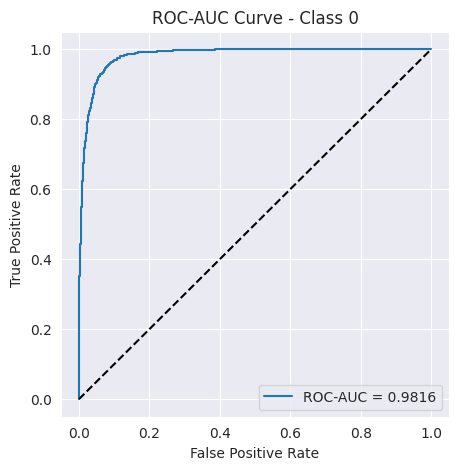

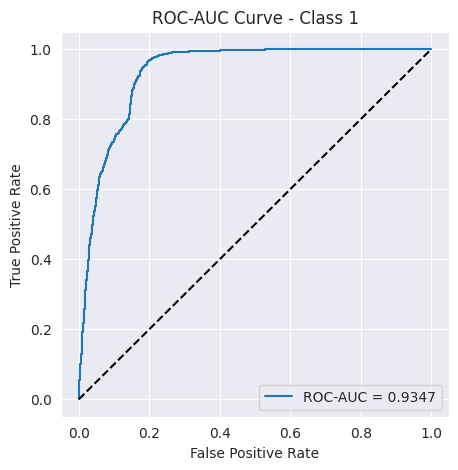

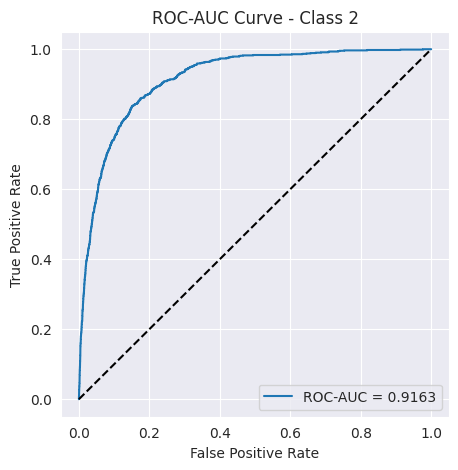

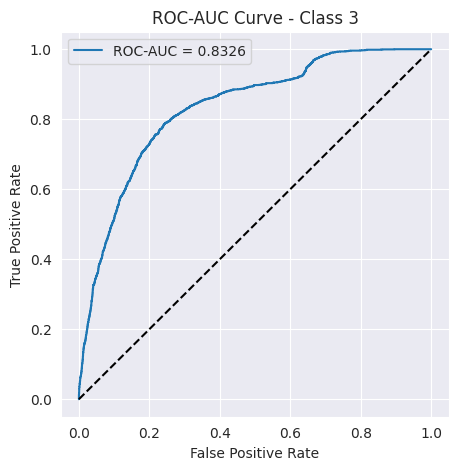

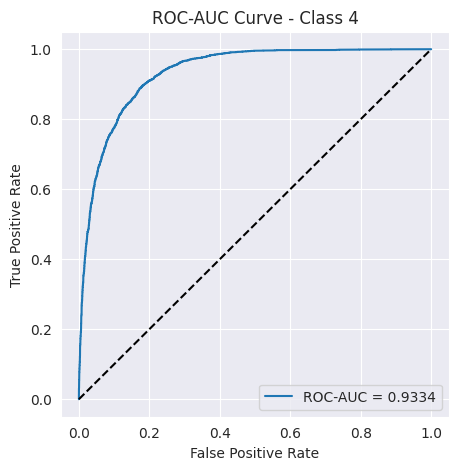

In [ ]:
plot_roc_auc(y_val_bin, y_pred_proba, classes)

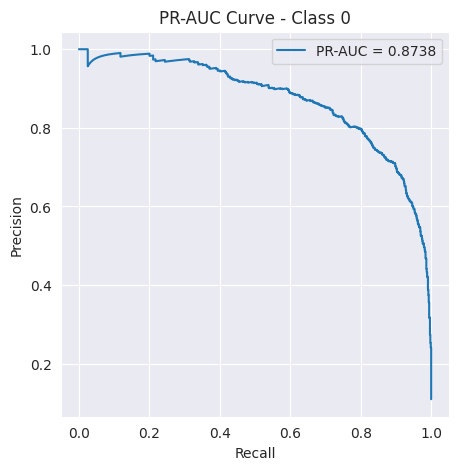

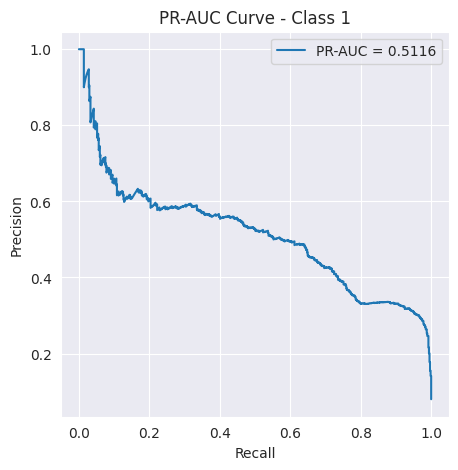

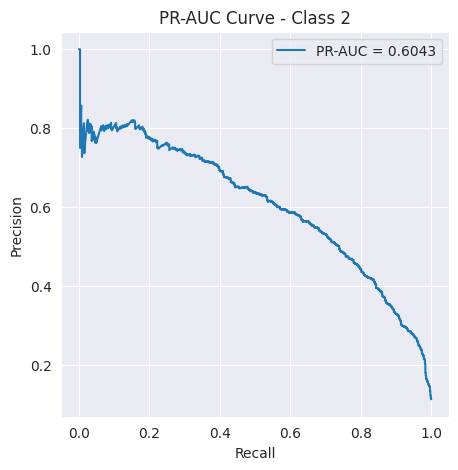

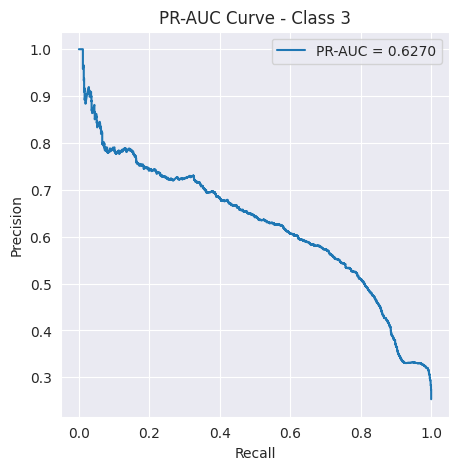

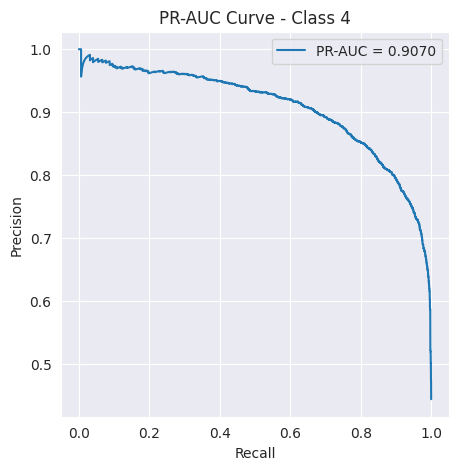

In [ ]:
plot_pr_auc(y_val_bin, y_pred_proba, classes)

In [ ]:
print('PR-AUC Score: ', average_precision_score(y_val_bin,y_pred_proba,average='macro'))

PR-AUC Score:  0.7050552494962894


In [ ]:
from sklearn.metrics import roc_auc_score

print('ROC-AUC Score:', roc_auc_score(y_val_true, y_pred_proba, multi_class='ovr'))

ROC-AUC Score: 0.9197163377641893


## Testing

In [ ]:
# define testing function

def test(model, dataloader, device, y_test_true):
    model.eval()
    preds = []
    probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Testing"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )

            logits = outputs.logits
            prob = torch.softmax(logits, dim=-1)

            preds.append(torch.argmax(logits, dim=-1).cpu().numpy())
            probs.append(prob.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    probs = np.concatenate(probs, axis=0)

    accuracy = accuracy_score(y_test_true, preds)
    f1 = f1_score(y_test_true, preds, average="macro")

    print(f"\nTest Accuracy: {accuracy:.4f}")
    print(f"Test Macro-F1: {f1:.4f}")
    print("\nClassification Report:\n",classification_report(y_test_true, preds))

    return accuracy, f1, preds, probs

In [ ]:
y_test_true = y_test.values
test_accuracy, test_f1, y_test_pred, probs_test = test(bert_model, test_loader, device, y_test_true)

Testing:   0%|          | 0/1249 [00:00<?, ?it/s]


Test Accuracy: 0.7260
Test Macro-F1: 0.6646

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.85      0.81      2182
           1       0.56      0.49      0.52      1597
           2       0.61      0.52      0.56      2271
           3       0.64      0.53      0.58      5057
           4       0.79      0.90      0.84      8864

    accuracy                           0.73     19971
   macro avg       0.68      0.66      0.66     19971
weighted avg       0.71      0.73      0.72     19971



## Suitable metrics

### Negative Log Likelihood

In [ ]:
# calculate negative log likelihood

def nll(probs, y_true, eps=1e-12):
    probs = np.clip(probs, eps, 1.0)
    nll = -np.log(probs[np.arange(len(y_true)), y_true]).mean()
    return nll

In [ ]:
nll_test = nll(probs_test, y_test_true)
print(f"Test NLL: {nll_test:.4f}")

Test NLL: 0.8610


In [ ]:
# baseline

nll_uniform = -np.log(1 / 5)
print(nll_uniform)

1.6094379124341003


### MAE

In [ ]:
probs = np.array(probs_test)
classes = np.arange(probs.shape[1])
y_pred_score = (probs * classes[None, :]).sum(axis=1)

mae = np.abs(y_pred_score - y_test_true).mean()
print("MAE:", mae)

MAE: 0.5146237974910305


### Off-by-one Accuracy

In [ ]:
y_pred_hard = probs.argmax(axis=1)

off1_acc = (np.abs(y_pred_hard - y_test_true) <= 1).mean()
print("Off-by-one Accuracy:", off1_acc)

Off-by-one Accuracy: 0.9841770567322617
